In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import random
from PIL import Image

In [5]:
def resize_image(image, target_size, coef=1):
    """
    Resizes an image to the given target size, optionally scaling by a coefficient.

    Parameters:
    image (PIL.Image): The image to be resized.
    target_size (tuple): A tuple (width, height) representing the target size for the image.
    coef (float, optional): A coefficient to scale the target size. Default is 1.

    Returns:
    PIL.Image: The resized image.
    """
    size = (target_size[0] * coef, target_size[1] * coef)
    return image.resize(size, Image.ANTIALIAS)

def generate_images(image, target_size, num_samples):
    """
    Generates new images by cropping the original image at random positions.

    Parameters:
    image (PIL.Image): The original image to generate samples from.
    target_size (tuple): A tuple (width, height) representing the size
                         of the generated images.
    num_samples (int): The number of samples to generate.

    Returns:
    list[PIL.Image]: A list of cropped images generated from the original image.
    """
    original_width, original_height = image.size
    target_width, target_height = target_size
    new_images = []

    for _ in range(num_samples):
        left = random.randint(0, original_width - target_width)
        top = random.randint(0, original_height - target_height)
        right = left + target_width
        bottom = top + target_height
        # print(left, top, right, bottom)
        cropped_image = image.crop((left, top, right, bottom))
        new_images.append(cropped_image)

    return new_images

def center_crop(image, target_size):
    """
    Crops the image to the specified target size from the center.

    Parameters:
    image (PIL.Image): The original image to be cropped.
    target_size (tuple): A tuple (width, height) representing the size of the cropped image.

    Returns:
    PIL.Image: The cropped image centered on the original image.
    """
    original_width, original_height = image.size
    target_width, target_height = target_size
    left = (original_width - target_width) // 2
    top = (original_height - target_height) // 2
    right = left + target_width
    bottom = top + target_height

    return image.crop((left, top, right, bottom))

def find_min_size(images):
    """
    Finds the minimum width and height among a list of images.

    Parameters:
    images (list[PIL.Image]): A list of images to evaluate.

    Returns:
    tuple: A tuple (min_width, min_height) representing the minimum width and height found among the images.
    """
    widths, heights = zip(*(img.size for img in images))
    return min(widths), min(heights)

def load_images_from_folder(folder):
    """
    Loads images from a specified folder.

    Parameters:
    folder (str): The path to the folder containing images.

    Returns:
    tuple: A tuple (images, filenames) where images is a list of loaded images (PIL.Image)
           and filenames is a list of corresponding filenames.
    """
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames

In [6]:
# Paths to data folders
handwritten_folder = '/content/drive/My Drive/CV_intern/TASK4/H'  # Handwrited images
printed_folder = '/content/drive/My Drive/CV_intern/TASK4/P'  # Printed images
train_folder = 'train'
test_folder = 'test'

# Images loading
handwritten_images, handwritten_filenames = load_images_from_folder(handwritten_folder)
printed_images, printed_filenames = load_images_from_folder(printed_folder)

print('Handwrited images: ', len(handwritten_images))
print('Printed images: ', len(printed_images))

Handwrited images:  27
Printed images:  29


In [7]:
# Finding the minimum image size
all_images = handwritten_images + printed_images
min_size = find_min_size(all_images)
min_size

(320, 157)

In [8]:
# Split on train and test
SPLIT_SIZE = 0.7
random.seed(42)
handwritten_split = int(SPLIT_SIZE * len(handwritten_images))
printed_split = int(SPLIT_SIZE * len(printed_images))

handwritten_train = handwritten_images[:handwritten_split]
handwritten_test = handwritten_images[handwritten_split:]
printed_train = printed_images[:printed_split]
printed_test = printed_images[printed_split:]

len(handwritten_train), len(printed_train), len(handwritten_test), len(printed_test)

(18, 20, 9, 9)

In [ ]:
# import shutil
# shutil.rmtree('train')
# shutil.rmtree('test')
# shutil.rmtree('test_full')
# shutil.rmtree('train_full')

In [9]:
# Creating new extend dataset by croping some random samples from image
num_samples = 50
for category, images, filenames, output_folder in [
    ('H', handwritten_train, handwritten_filenames[:handwritten_split], train_folder),
    ('H', handwritten_test, handwritten_filenames[handwritten_split:], test_folder),
    ('P', printed_train, printed_filenames[:printed_split], train_folder),
    ('P', printed_test, printed_filenames[printed_split:], test_folder)
    ]:
    if not os.path.exists(os.path.join(output_folder, category)):
        os.makedirs(os.path.join(output_folder, category))
        os.makedirs(os.path.join(output_folder+'_full', category))

    for idx, img in enumerate(images):
        filename = filenames[idx]
        if output_folder == train_folder:
            resized_image = resize_image(img, min_size, coef=3)
            # save full resized image
            resize_image(img, min_size, coef=1).save(f'train_full/{category}/{category}_test_{idx}.png')
            new_images = generate_images(resized_image, min_size, num_samples)
            for jdx, new_img in enumerate(new_images):
                new_img.save(os.path.join(output_folder, category, f'{category}_train_{idx}_{jdx}.png'))
        else:
            num_samples = 20
            resized_image = resize_image(img, min_size, coef=3)
            # save full resized image
            resize_image(img, min_size, coef=1).save(f'test_full/{category}/{category}_test_{idx}.png')
            new_images = generate_images(resized_image, min_size, num_samples)
            for jdx, new_img in enumerate(new_images):
                new_img.save(os.path.join(output_folder, category, f'{category}_test_{idx}_{jdx}.png'))

<ipython-input-5-e9ec5770fdeb>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return image.resize(size, Image.ANTIALIAS)


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_learning_history(history):
    """
    Plots the training and validation loss and accuracy from the history of a model's training process.

    Parameters:
    history (tensorflow.keras.callbacks.History): A History object returned by the fit method of a Keras model. It contains training and validation metrics for each epoch.

    Returns:
    None: The function plots the graphs but does not return any values.
    """
    # Extracting metric values from history
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    epochs = range(1, len(training_loss) + 1)

    # Plotting loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, 'b-', label='Training loss')
    plt.plot(epochs, validation_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, 'b-', label='Training accuracy')
    plt.plot(epochs, validation_accuracy, 'r-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
np.random.seed(13)
tf.random.set_seed(13)

batch_size = 32
img_size = min_size


# Image generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['H', 'P'],
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    classes=['H', 'P']
)

Found 1300 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


In [12]:
# Class Labels
test_generator.class_indices

{'H': 0, 'P': 1}

In [13]:
(train_generator.classes == 0).sum(), (train_generator.classes == 1).sum()

(900, 400)

In [14]:
(test_generator.classes == 0).sum(), (test_generator.classes == 1).sum()

(180, 180)

In [15]:
train_generator[0][0][0].shape

(320, 157, 3)

### Logistic regression

Epoch 1/10
41/41 [==============================] - 6s 89ms/step - loss: 25.2885 - accuracy: 0.5908 - val_loss: 1.1325 - val_accuracy: 0.5056
Epoch 2/10
41/41 [==============================] - 4s 88ms/step - loss: 6.9110 - accuracy: 0.5654 - val_loss: 0.9983 - val_accuracy: 0.5028
Epoch 3/10
41/41 [==============================] - 10s 248ms/step - loss: 10.2216 - accuracy: 0.5831 - val_loss: 1.2903 - val_accuracy: 0.5028
Epoch 4/10
41/41 [==============================] - 6s 135ms/step - loss: 9.6339 - accuracy: 0.5762 - val_loss: 5.2654 - val_accuracy: 0.5000
Epoch 5/10
41/41 [==============================] - 4s 101ms/step - loss: 9.3885 - accuracy: 0.5792 - val_loss: 10.3031 - val_accuracy: 0.5000
Epoch 6/10
41/41 [==============================] - 4s 107ms/step - loss: 10.4438 - accuracy: 0.5885 - val_loss: 9.5831 - val_accuracy: 0.5000
Epoch 7/10
41/41 [==============================] - 4s 89ms/step - loss: 4.4812 - accuracy: 0.5892 - val_loss: 5.1999 - val_accuracy: 0.5000
Epoc

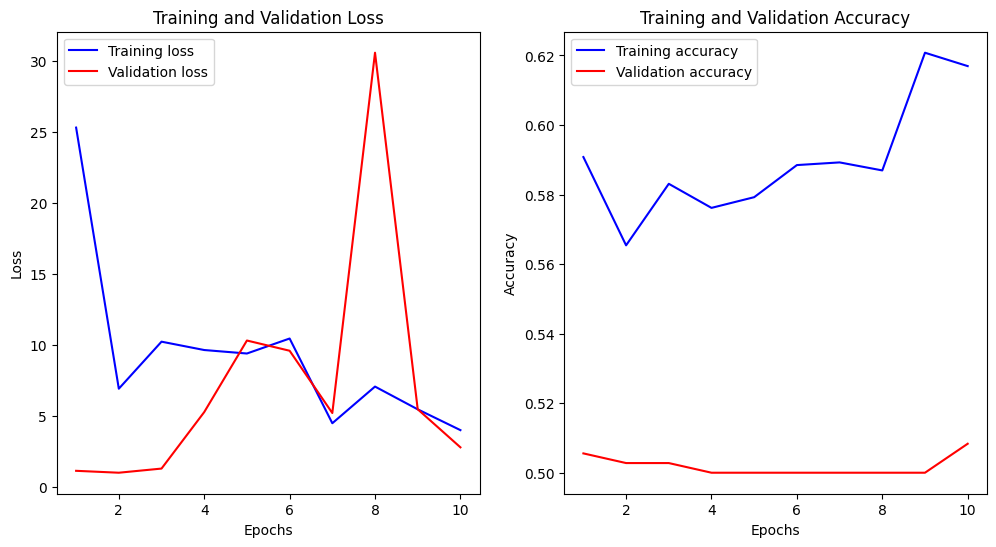

In [18]:
model = Sequential([
    Flatten(input_shape=(img_size[0], img_size[1], 3)),
    Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=10, validation_data=test_generator, )

loss, accuracy = model.evaluate(test_generator)
print(f'Accuracy: {accuracy}')

plot_learning_history(history)

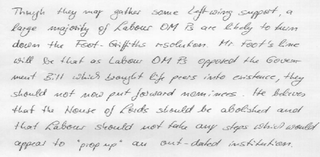

In [ ]:
t1 = Image.open('/content/test_full/H/H_test_0.png')
t1

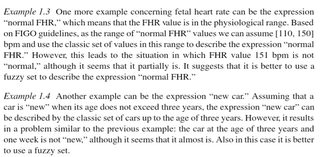

In [22]:
Image.open('/content/test_full/P/P_test_0.png')

In [23]:
def preprocess_image(image, image_size=(320,157)):
    img = image.convert('RGB').resize(image_size)
    img_array = np.array(img).T / 255.0
    # print(img.size, img_array.size, img_array.shape)

    if img_array.shape[0] == 4:
      img_array = img_array[:, :, :3]
    # print(img.size, img_array.size, img_array.shape)
    img_array = img_array.transpose((1, 2, 0))
    img_array = np.expand_dims(img_array, axis=0)
    # print(img.size, img_array.size, img_array.shape)
    return img_array

test_image = Image.open('/content/test_full/H/H_test_0.png')  # Load an image
test_image_label = 0
img_array = preprocess_image(test_image)
prediction = model.predict(img_array)
prediction_probability = prediction[0][0]

# Presiction Example
if prediction_probability > 0.5:
    prediction_label = "Printed Text"
else:
    prediction_label = "Handwritten Text"
print(prediction_label, f'Probability: {prediction_probability:.2f}',
      '>> Wrong prediction!!!' if round(prediction_probability) != test_image_label else 'Good job!!!')

test_image = Image.open('/content/test_full/P/P_test_0.png')  # Load an image
test_image_label = 1
img_array = preprocess_image(test_image)
prediction = model.predict(img_array)
prediction_probability = prediction[0][0]

# Presiction Example
if prediction_probability > 0.5:
    prediction_label = "Printed Text"
else:
    prediction_label = "Handwritten Text"
print(prediction_label, f'Probability: {prediction_probability:.2f}',
      '>> Wrong prediction!!!' if round(prediction_probability) != test_image_label else '>> Good job!!!')

1/1 [==============================] - 0s 18ms/step
Printed Text Probability: 1.00 >> Wrong prediction!!!
1/1 [==============================] - 0s 16ms/step
Printed Text Probability: 0.99 >> Good job!!!


### Simple CNN

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout

# Модель CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Навчання моделі
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

# Оцінка моделі
loss, accuracy = model.evaluate(test_generator)
print(f'Accuracy: {accuracy}')


Epoch 1/10
41/41 [==============================] - 12s 144ms/step - loss: 2.1825 - accuracy: 0.6662 - val_loss: 0.6540 - val_accuracy: 0.5000
Epoch 2/10
41/41 [==============================] - 6s 136ms/step - loss: 0.3817 - accuracy: 0.7377 - val_loss: 0.6587 - val_accuracy: 0.6500
Epoch 3/10
41/41 [==============================] - 5s 111ms/step - loss: 0.2664 - accuracy: 0.9108 - val_loss: 0.5534 - val_accuracy: 0.6833
Epoch 4/10
41/41 [==============================] - 4s 108ms/step - loss: 0.2340 - accuracy: 0.9323 - val_loss: 0.6121 - val_accuracy: 0.6861
Epoch 5/10
41/41 [==============================] - 6s 139ms/step - loss: 0.0683 - accuracy: 0.9777 - val_loss: 0.8759 - val_accuracy: 0.6583
Epoch 6/10
41/41 [==============================] - 4s 107ms/step - loss: 0.0311 - accuracy: 0.9892 - val_loss: 0.7651 - val_accuracy: 0.6694
Epoch 7/10
41/41 [==============================] - 5s 120ms/step - loss: 0.0156 - accuracy: 0.9969 - val_loss: 0.8572 - val_accuracy: 0.6861
Epoch

1/1 [==============================] - 0s 17ms/step


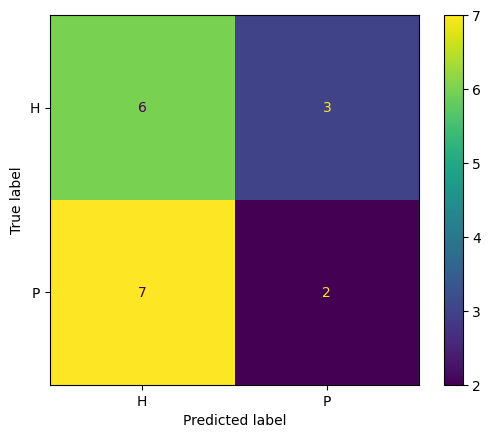

In [ ]:
test_H = load_images_from_folder('/content/test_full/H')[0]
test_P = load_images_from_folder('/content/test_full/P')[0]
labels = [0] * len(test_H) + [1] * len(test_P)
pred = []
for h_img in test_H:
    img_array = preprocess_image(h_img)
    prediction = round(model.predict(img_array)[0][0])
    pred.append(prediction)
for p_img in test_P:
    img_array = preprocess_image(p_img)
    prediction = round(model.predict(img_array)[0][0])
    pred.append(prediction)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, pred)
ConfusionMatrixDisplay(cm, display_labels=['H', 'P']).plot()

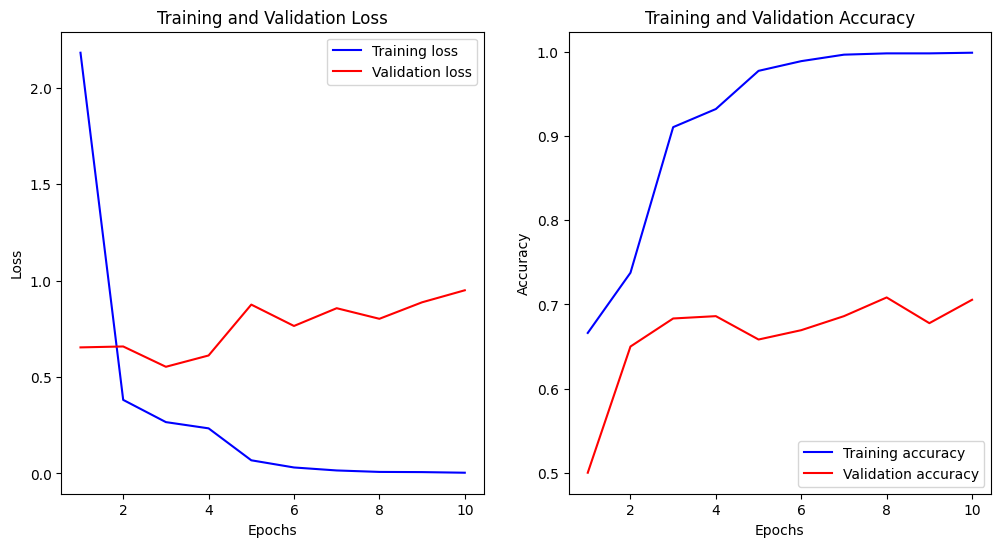

In [ ]:
plot_learning_history(history)


### More complex CNN

Epoch 1/10
41/41 [==============================] - 7s 103ms/step - loss: 0.7113 - accuracy: 0.6846 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 2/10
41/41 [==============================] - 4s 106ms/step - loss: 0.5588 - accuracy: 0.6923 - val_loss: 0.5838 - val_accuracy: 0.5000
Epoch 3/10
41/41 [==============================] - 6s 134ms/step - loss: 0.3736 - accuracy: 0.8600 - val_loss: 0.5557 - val_accuracy: 0.7444
Epoch 4/10
41/41 [==============================] - 4s 97ms/step - loss: 0.2594 - accuracy: 0.9146 - val_loss: 0.4872 - val_accuracy: 0.7444
Epoch 5/10
41/41 [==============================] - 4s 93ms/step - loss: 0.1419 - accuracy: 0.9577 - val_loss: 0.5946 - val_accuracy: 0.7528
Epoch 6/10
41/41 [==============================] - 5s 128ms/step - loss: 0.0745 - accuracy: 0.9769 - val_loss: 0.7946 - val_accuracy: 0.7222
Epoch 7/10
41/41 [==============================] - 4s 93ms/step - loss: 0.1180 - accuracy: 0.9677 - val_loss: 0.8742 - val_accuracy: 0.7222
Epoch 8/1

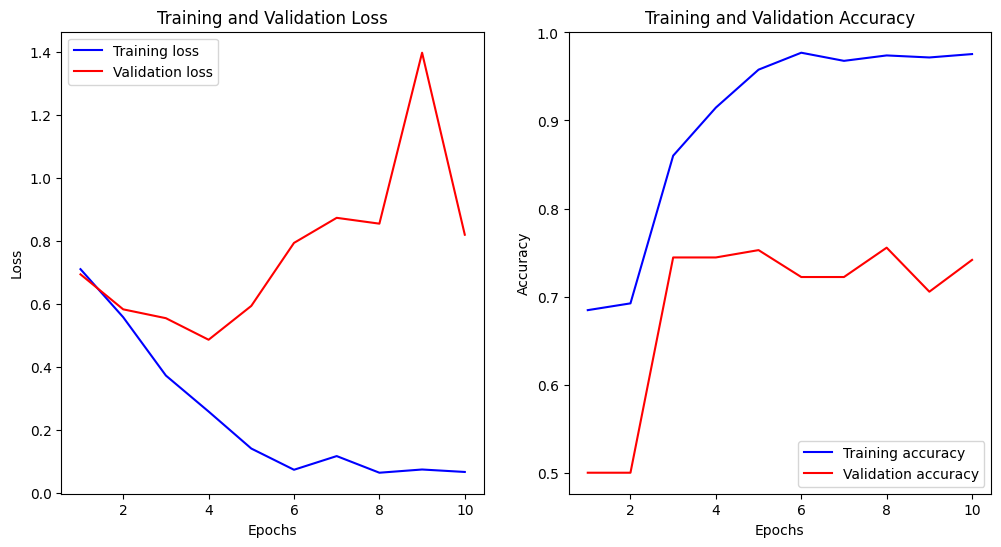

In [ ]:
model2 = Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
        Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model2.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics='accuracy')
history2 = model2.fit(train_generator, epochs=10, verbose=1,
                    validation_data = test_generator)

loss2, accuracy2 = model2.evaluate(test_generator)
print()
print(f'Accuracy: {accuracy2}')

plot_learning_history(history2)

1/1 [==============================] - 0s 78ms/step


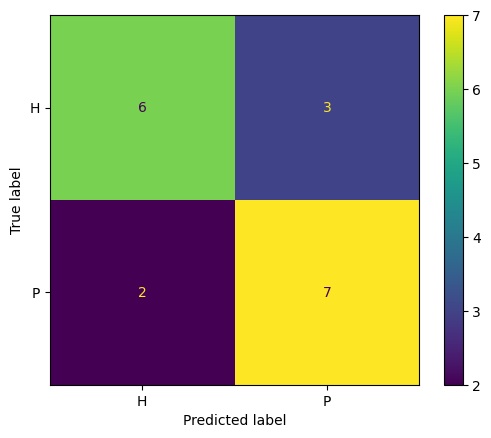

In [ ]:
pred = []
for img in test_H + test_P:
    img_array = preprocess_image(img)
    prediction = round(model2.predict(img_array)[0][0])
    pred.append(prediction)

cm = confusion_matrix(labels, pred)
ConfusionMatrixDisplay(cm, display_labels=['H', 'P']).plot()

In [ ]:
model2.save('/content/drive/My Drive/CV_intern/TASK4/model_more_complex_CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 318, 155, 16)      448       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 159, 77, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_43 (Dropout)        (None, 159, 77, 16)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 157, 75, 32)       4640      
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 78, 37, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_44 (Dropout)        (None, 78, 37, 32)      

### CNN based on pretrained ResNet50

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/15
8/8 [==============================] - 9s 408ms/step - loss: 0.6055 - accuracy: 0.7070 - val_loss: 0.7258 - val_accuracy: 0.4961
Epoch 2/15
8/8 [==============================] - 2s 250ms/step - loss: 0.5460 - accuracy: 0.7148 - val_loss: 0.5387 - val_accuracy: 0.6445
Epoch 3/15
8/8 [==============================] - 4s 571ms/step - loss: 0.4153 - accuracy: 0.8156 - val_loss: 0.5491 - val_accuracy: 0.6523
Epoch 4/15
8/8 [==============================] - 2s 285ms/step - loss: 0.3865 - accuracy: 0.8672 - val_loss: 0.5538 - val_accuracy: 0.6484
Epoch 5/15
8/8 [==============================] - 2s 311ms/step - loss: 0.3761 - accuracy: 0.8086 - val_loss: 0.7462 - val_accuracy: 0.6367
Epoch 6/15
8/8 [==============================] - 2s 256ms/step - loss: 0.3469 - accuracy: 0.8398 - val_loss: 0.5874 - val_accuracy: 0.6523
Epoch 7/15
8/8 [==============================] - 2s 252ms/step - loss: 0.3471 - accuracy: 0.86

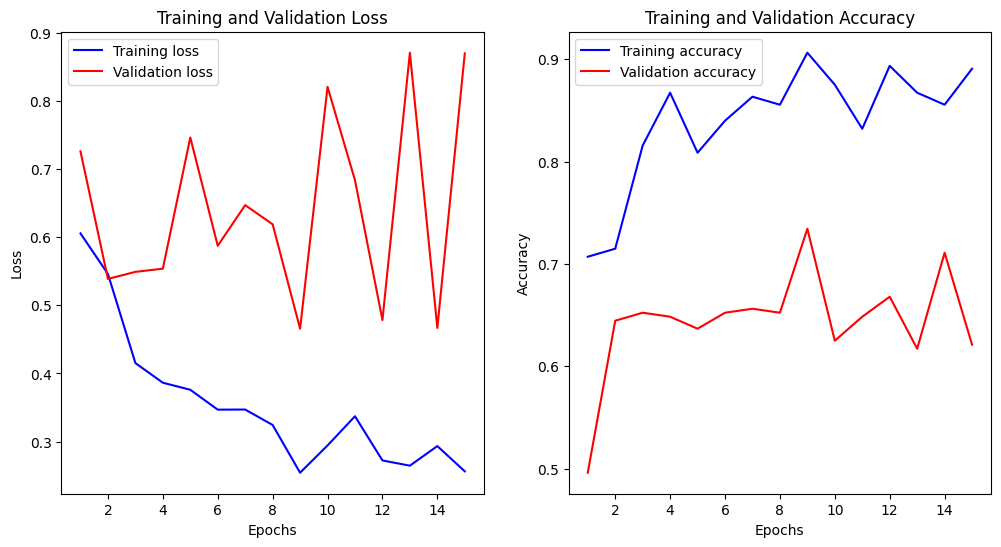

In [44]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

# Loading pretrained base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Frozing base model layers
base_model.trainable = False

# Adding new layers for training
model3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    # Dense(512, activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Навчання моделі
history3 = model3.fit(train_generator, epochs=15, verbose=1, steps_per_epoch=8, validation_steps=8,
                    validation_data = test_generator)

# Оцінка моделі
loss3, accuracy3 = model3.evaluate(test_generator)
print(f'Accuracy: {accuracy3}')
plot_learning_history(history3)


1/1 [==============================] - 0s 35ms/step
Accuracy on full resized test images:  0.78


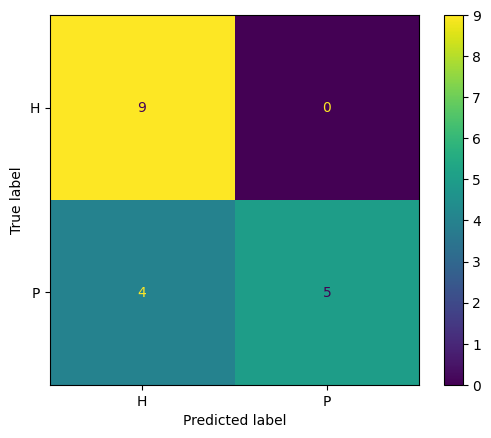

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

pred = []
for img in test_H + test_P:
    img_array = preprocess_image(img)
    prediction = round(model3.predict(img_array)[0][0])
    pred.append(prediction)

cm = confusion_matrix(labels, pred)
ConfusionMatrixDisplay(cm, display_labels=['H', 'P']).plot()
print(f'Accuracy on full resized test images: ', round(accuracy_score(labels, pred), 2))

In [47]:
model3.save('/content/drive/My Drive/CV_intern/TASK4/CNN_resnet50based.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 5, 2048)       23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_30 (Dropout)        (None, 2048)              0         
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               1049088   
                                                                 
 dense_14 (Dense)            (None, 1)                 513       
                                                      

In [49]:
model3.save_weights('/content/drive/My Drive/CV_intern/TASK4/CNN_resnet50based_weights.h5')